# Value Investor- A Forecasting Project

Background:


There is a portfolio investment company and they make investments in the emerging markets around the world. Our company profits by investing in profitable companies, buying, holding and selling company stocks based on value investing principles.


Their goal is to establish a robust intelligent system to aid their value investing efforts using stock market data. They make investment decisions and based on intrinsic value of companies and do not trade on the basis of daily market volatility. Their profit realization strategy typically involves weekly, monthly and quarterly performance of stocks they buy or hold.

In [29]:
# Importing libraries relevant to Moving Avg, Exp. Moving Avg, LSTM, and Facebook Prophet

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import math


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *

from sklearn.preprocessing import  MinMaxScaler
from statsmodels.tsa.api import SimpleExpSmoothing

from prophet import Prophet
from matplotlib.dates import DateFormatter
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [30]:
stock_Data_path=pd.ExcelFile('C:/Users/97158/Desktop/Apziva/Project 5-Value Investor/2020Q1Q2Q3Q4-2021Q1.xlsx')

In [31]:
sheet_names=stock_Data_path.sheet_names

dfs={}

for sheet_name in sheet_names:
    df=pd.read_excel(stock_Data_path,sheet_name=sheet_name)
    dfs[sheet_name]=df

In [32]:
sheet_names

['Russia - Sberbank Rossii PAO (S',
 'Turkey - Koc Holding AS (KCHOL)',
 'Egypt - Medinet Nasr Housing (M',
 'Brazil - Minerva SABrazil (BEEF',
 'Argentina - Pampa Energia SA (P',
 'Colombia - Cementos Argos SA (C',
 'South Africa - Impala Platinum ',
 'South Korea - Dongkuk Steel Mil']

In [33]:
#Removing unwanted Rows

Russia=dfs[sheet_names[0]].iloc[:-1,:]
Turkey=dfs[sheet_names[1]].iloc[:-1,:]
Egypt=dfs[ sheet_names[2]].iloc[:-1,:]
Brazil=dfs[sheet_names[3]].iloc[:-1,:]
Argentina=dfs[sheet_names[4]].iloc[:-1,:]
Colombia=dfs[sheet_names[5]].iloc[:-1,:]
South_Africa=dfs[sheet_names[6]].iloc[:-1,:]
South_Korea=dfs[sheet_names[7]].iloc[:-1,:]

In [34]:
# Cleaning and standardizing the dataset

Russia[['Country', 'Stock']] = pd.DataFrame([['Russia', 'Sberbank_Rossii_PAO']], index=Russia.index)
Turkey[['Country', 'Stock']] = pd.DataFrame([['Turkey', 'Koc_Holding_AS']], index=Turkey.index)
Egypt[['Country', 'Stock']] = pd.DataFrame([['Egypt', 'Medinet_Nasr_Housing']], index=Egypt.index)
Brazil[['Country', 'Stock']] = pd.DataFrame([['Brazil', ' Minerva_SABrazil']], index=Brazil.index)
Argentina[['Country', 'Stock']] = pd.DataFrame([['Argentina', 'Pampa_Energia_SA']], index=Argentina.index)
Colombia[['Country', 'Stock']] = pd.DataFrame([['Colombia', 'Cementos_Argos_SA']], index=Colombia.index)
South_Africa[['Country', 'Stock']] = pd.DataFrame([['South_Africa', 'Impala_Platinum']], index=South_Africa.index)
South_Korea[['Country', 'Stock']] = pd.DataFrame([['South_Korea', 'Dongkuk_Steel_Mil']], index=South_Korea.index)

C:\Users\97158\AppData\Local\Temp\ipykernel_32784\89466984.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Russia[['Country', 'Stock']] = pd.DataFrame([['Russia', 'Sberbank_Rossii_PAO']], index=Russia.index)
C:\Users\97158\AppData\Local\Temp\ipykernel_32784\89466984.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Russia[['Country', 'Stock']] = pd.DataFrame([['Russia', 'Sberbank_Rossii_PAO']], index=Russia.index)
C:\Users\97158\AppData\Local\Temp\ipykernel_32784\89466984.py:4: SettingWithCopyWarning:

In [35]:
# Consolidating the dataset

Consol_data=pd.concat([Russia,Turkey,Egypt,Brazil,Argentina, Colombia, South_Africa, South_Korea])
data_order=['Stock','Country','Date', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'Price']
Consol_data=Consol_data[data_order]
Consol_data['Date']=pd.to_datetime(Consol_data['Date'])
Consol_data

,Stock,Country,Date,Open,High,Low,Vol.,Change %,Price
0,Sberbank_Rossii_PAO,Russia,2021-03-31,294,294.42,290.26,47.00M,-0.0076,291.02
1,Sberbank_Rossii_PAO,Russia,2021-03-30,294.86,295.72,291.5,38.81M,-0.0002,293.25
2,Sberbank_Rossii_PAO,Russia,2021-03-29,289.72,294.09,289.26,43.68M,0.0071,293.3
3,Sberbank_Rossii_PAO,Russia,2021-03-26,288.63,292.75,288.32,56.07M,0.0159,291.22
4,Sberbank_Rossii_PAO,Russia,2021-03-25,286.5,287.03,283.85,35.22M,0.0030,286.66
...,...,...,...,...,...,...,...,...,...
336,Dongkuk_Steel_Mil,South_Korea,2020-01-08,5640,5640,5390,524.10K,-0.0457,5430
337,Dongkuk_Steel_Mil,South_Korea,2020-01-07,5740,5770,5650,303.89K,-0.0070,5690
338,Dongkuk_Steel_Mil,South_Korea,2020-01-06,5890,5890,5680,319.88K,-0.0288,5730
339,Dongkuk_Steel_Mil,South_Korea,2020-01-03,5870,5920,5830,230.40K,0.0085,5900


In [36]:
# Converting unit strings into absolute values

def vol_converter(data):
    if data.endswith('M'):
        return float(data.rstrip('M'))*1000000
    elif data.endswith('K'):
        return float(data.rstrip('K'))*1000
    elif data.endswith('-'):
        return float(0)
    else :
        return float(data)
    
Consol_data['Vol.']=Consol_data['Vol.'].apply(vol_converter)  

C:\Users\97158\AppData\Local\Temp\ipykernel_32784\4013710093.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Date'] = pd.to_datetime(country_data['Date'])
C:\Users\97158\AppData\Local\Temp\ipykernel_32784\4013710093.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Date'] = pd.to_datetime(country_data['Date'])
C:\Users\97158\AppData\Local\Temp\ipykernel_32784\4013710093.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

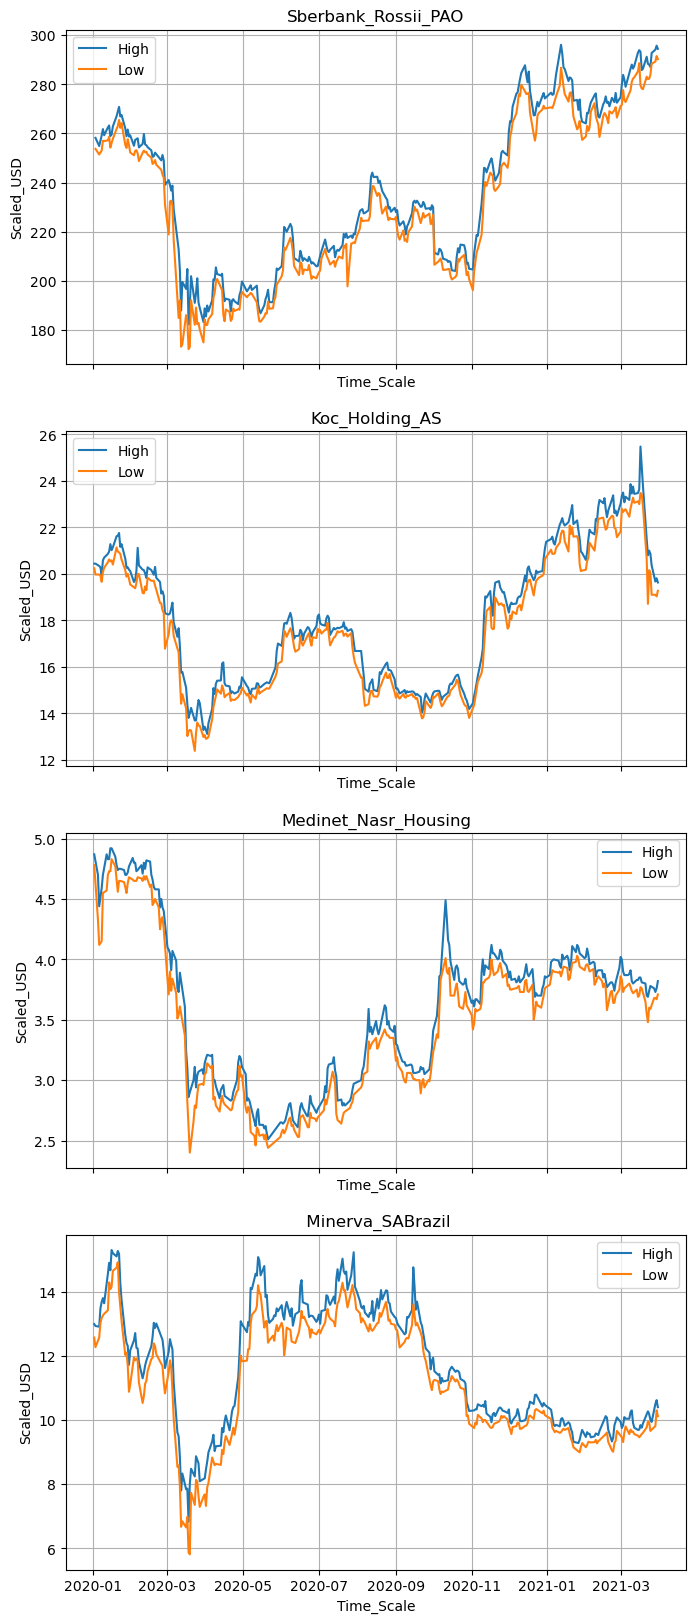

In [37]:
# Plotting charts of raw data for 4 stocks


Stock_list=Consol_data['Stock'].unique()[:4]

# Create subplots
fig, axs = plt.subplots(len(Stock_list),1, figsize=(8, 5 * len(Stock_list)), sharex=True)

# Iterate over each country
for i, Stock_name in enumerate(Stock_list):

    # Select data for the current country
    country_data = Consol_data[Consol_data['Stock'] == Stock_name]
    
    # Convert 'Date' column to datetime
    country_data['Date'] = pd.to_datetime(country_data['Date'])

    # Plot 'High' and 'Low' for the current country
    axs[i].plot(country_data['Date'], country_data['High'], label='High')
    axs[i].plot(country_data['Date'], country_data['Low'], label='Low')
    axs[i].set_title(Stock_name)  # Set title as country name
    axs[i].set_xlabel('Time_Scale')
    axs[i].set_ylabel('Scaled_USD')
    axs[i].legend()
    axs[i].grid(True)


plt.show()

# Moving Average

In [38]:
# Selecting relevant fields
Consol_data.iloc[:,[0,1,2,-1]]

,Stock,Country,Date,Price
0,Sberbank_Rossii_PAO,Russia,2021-03-31,291.02
1,Sberbank_Rossii_PAO,Russia,2021-03-30,293.25
2,Sberbank_Rossii_PAO,Russia,2021-03-29,293.3
3,Sberbank_Rossii_PAO,Russia,2021-03-26,291.22
4,Sberbank_Rossii_PAO,Russia,2021-03-25,286.66
...,...,...,...,...
336,Dongkuk_Steel_Mil,South_Korea,2020-01-08,5430
337,Dongkuk_Steel_Mil,South_Korea,2020-01-07,5690
338,Dongkuk_Steel_Mil,South_Korea,2020-01-06,5730
339,Dongkuk_Steel_Mil,South_Korea,2020-01-03,5900


In [39]:
def Create_MA(Raw_data, Stock):
    Consol_data=Raw_data[Raw_data['Stock']== Stock]
    MA_Data=Consol_data.iloc[:,[0,1,2,-1]]
    MA_Data=MA_Data.sort_values(by='Date')
    
    MA_Data['7MA']=np.round(MA_Data['Price'].rolling(window=7).mean(),2)
    MA_Data['30MA']=np.round(MA_Data['Price'].rolling(window=30).mean(),2)
    MA_Data['90MA']=np.round(MA_Data['Price'].rolling(window=90).mean(),2)
    return MA_Data

In [40]:
def Plot_MA(MA_Data, Stock):
    MA_Data=MA_Data[MA_Data['Stock']== Stock]
    plt.figure(figsize=(14,6))
    plt.title(Stock+' '+'Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.plot(MA_Data['Date'],MA_Data['Price'],color='orange')
    plt.plot(MA_Data['Date'],MA_Data['7MA'],color='green',linestyle='--')
    plt.plot(MA_Data['Date'],MA_Data['30MA'],color='blue',linestyle='--')
    plt.plot(MA_Data['Date'],MA_Data['90MA'],color='red',linestyle='--')

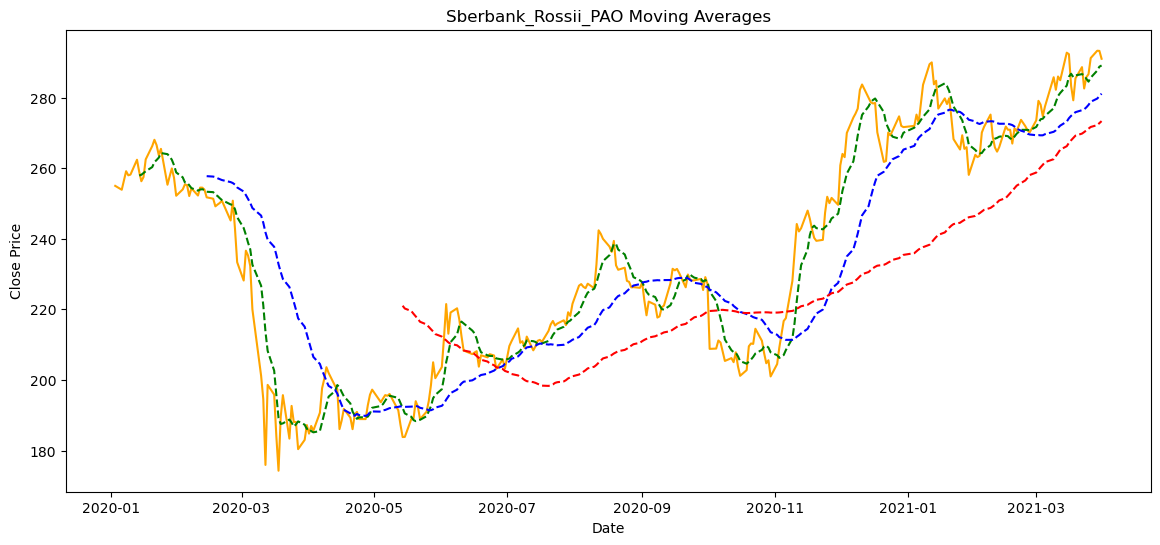

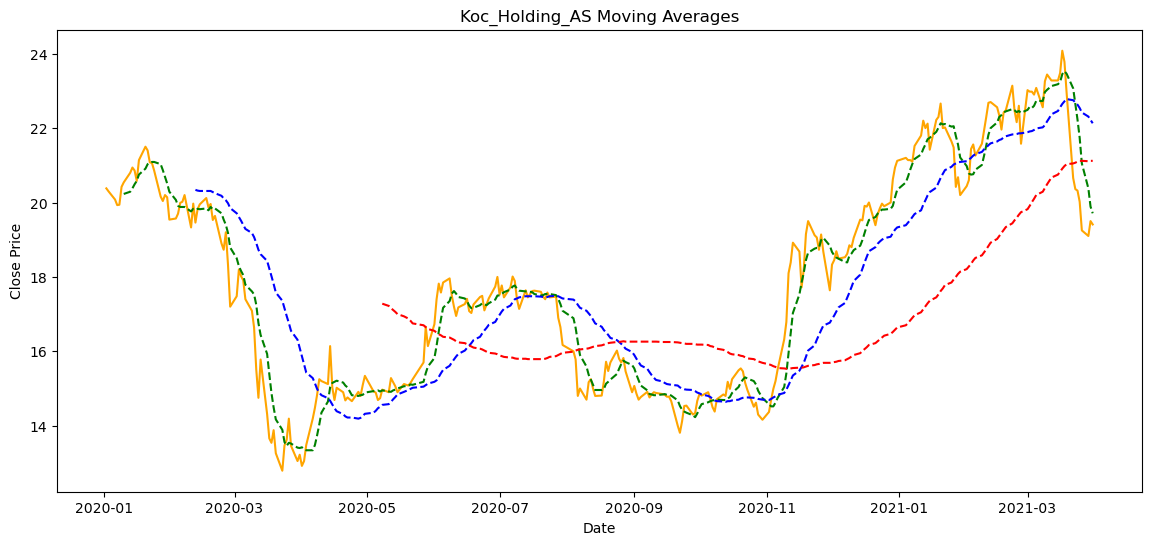

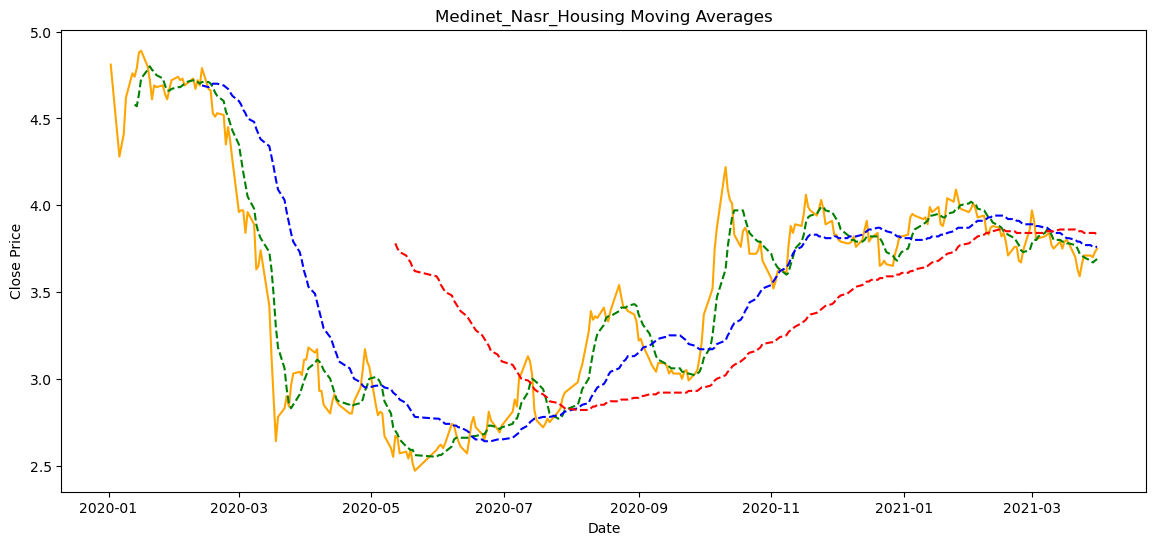

In [41]:
# Calculating and plotting curves for all the stocks. 

# Calculating and plotting Moving Avg. for first 3 stocks
Stocks=Consol_data['Stock'].unique()[:3]
All_MA_Data=pd.DataFrame()

for Stock in Stocks:
    MA_Data= Create_MA(Consol_data, Stock)
    All_MA_Data=pd.concat([All_MA_Data, MA_Data])
    Plot_MA(All_MA_Data, Stock)

# Exponential Moving Average

In [42]:
def Create_EMA(Raw_data, Stock, Span):
    Consol_data=Raw_data[Raw_data['Stock']== Stock]
    EMA_Data=Consol_data.iloc[:,[0,1,2,-1]]
    EMA_Data=EMA_Data.sort_values(by='Date')

    span= Span
    alpha= 2/(span+1)
    
    model=SimpleExpSmoothing(EMA_Data['Price'].values)
    fit_model=model.fit(smoothing_level=alpha, optimized=False)
    EMA_Data['EWMA']=pd.Series(fit_model.fittedvalues).shift(-1)
    return EMA_Data

In [43]:
def Plot_EMA(EMA_Data, Stock):
    EMA_Data=EMA_Data[EMA_Data['Stock']== Stock]
    plt.figure(figsize=(14,6))
    plt.title(Stock+' '+'Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.plot(EMA_Data['Date'],EMA_Data['Price'],color='orange')
    plt.plot(EMA_Data['Date'],EMA_Data['EWMA'],color='green',linestyle='--')

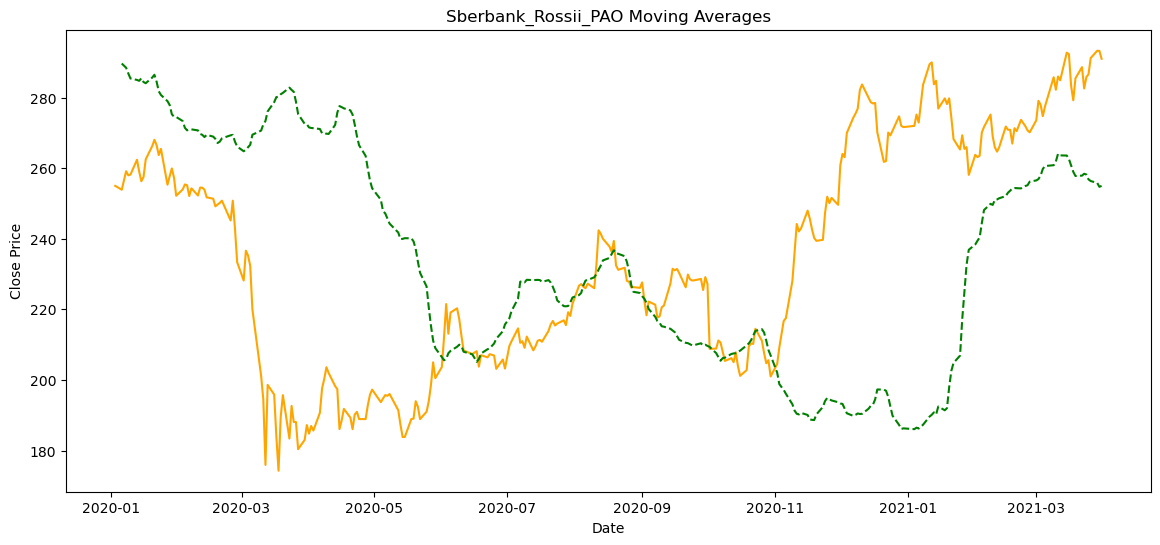

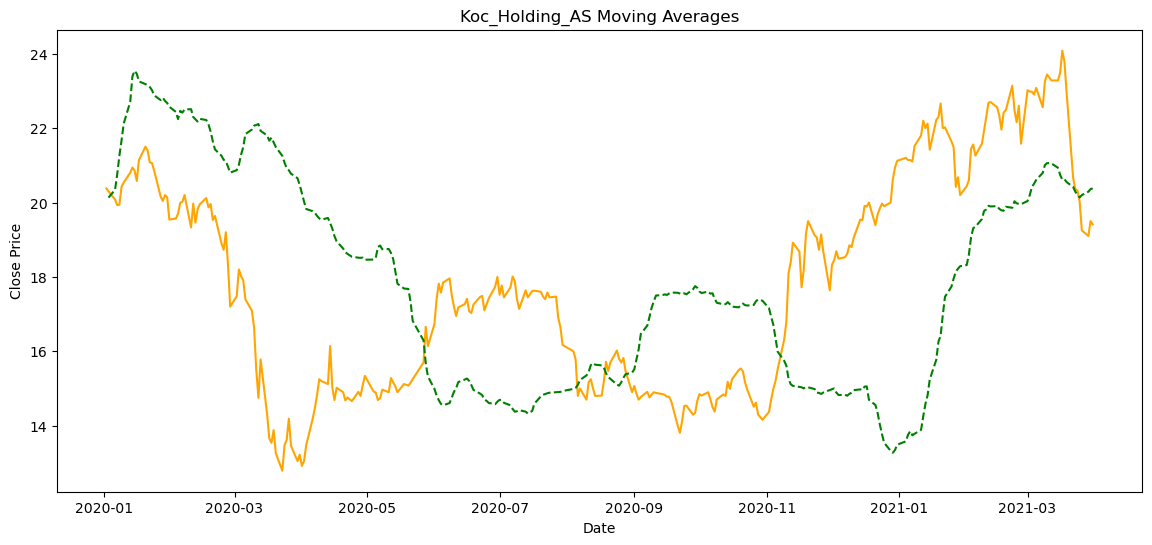

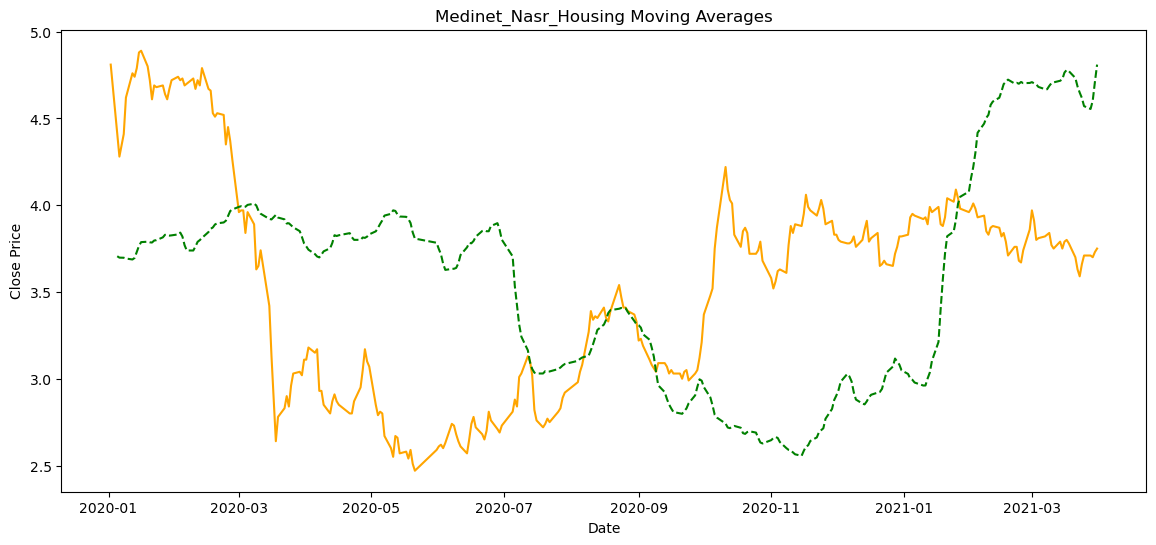

In [44]:
# Calculating and plotting curves for all the stocks. 

# Calculating and plotting Exponential Moving Avg. for first 3 stocks
Stocks=Consol_data['Stock'].unique()[:3]
All_EMA_Data=pd.DataFrame()

for Stock in Stocks:
    EMA_Data= Create_EMA(Consol_data, Stock,7)
    All_EMA_Data=pd.concat([All_EMA_Data, EMA_Data])
    Plot_EMA(All_EMA_Data, Stock)

# LSTM Model

In [45]:
# Defining the LSTM model architecture
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error',run_eagerly=True)
    return model

In [46]:
# Defining the LSTM split sequence
def split_sequence(sequence, n_steps):
    X, Y = [], []

    for i in range(len(sequence)):
        end_idx = i + n_steps
        if end_idx > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_idx], sequence[end_idx]
        X.append(seq_x)
        Y.append(seq_y)

    return np.array(X), np.array(Y)

In [47]:
def Train_LSTM(Raw_data, Stock, n_steps):
    # Filter data for the current country
    country_data = Raw_data[Raw_data['Stock'] == Stock]
        
    # Extract the price data for the current country
    price_data = country_data['Price'].values.astype(float)
        
    # Normalize the price data
    scaler = MinMaxScaler(feature_range=(0, 1))
    price_data_scaled = scaler.fit_transform(price_data.reshape(-1, 1))

    data_concat=pd.concat([country_data,pd.Series(price_data_scaled.reshape(-1))],axis=1)
        
    Train_data_scaled=data_concat[data_concat['Date']<='2020-12-31']
    Test_data_scaled=data_concat[data_concat['Date']>'2020-12-31']

    Train_price_scaled=Train_data_scaled.iloc[:,-1]
    Train_price_scaled=np.array(Train_price_scaled)

        
    # Split the sequence for the current country
    X_train_country, Y_train_country = split_sequence(Train_price_scaled, n_steps)

    # Reshape the input data
    X_train_country = X_train_country.reshape((X_train_country.shape[0], n_steps, 1))

    # Train the LSTM model
    model = create_lstm_model((X_train_country.shape[1], 1))
    model.fit(X_train_country, Y_train_country, epochs=10, batch_size=2, verbose=0)
    
    return Test_data_scaled, model, scaler, n_steps, Train_data_scaled

In [48]:
def Predict_LSTM(Test_data, model, scaler, n_steps):

    Test_price_scaled=Test_data.iloc[:,-1]
    Test_price_scaled=np.array(Test_price_scaled)

    X_test_country, Y_test_country = split_sequence(Test_price_scaled, n_steps)
    X_test_country = X_test_country.reshape((X_test_country.shape[0], n_steps, 1))

    test_predict= model.predict(X_test_country)
    test_predict= np.round(scaler.inverse_transform(test_predict))

    Predicted_data=Test_data.iloc[n_steps:,[0,1,2,-2]]
    Predicted_data['Test_predicted']=test_predict
    
    return Predicted_data

In [49]:
def Calculate_bands_and_plot(Train_data, test_and_predicted_data,Stock):

    Bband_data=pd.concat([Train_data,test_and_predicted_data])
    Bband_data=Bband_data.sort_values(by='Date',ascending=True)
    Bband_data=Bband_data.iloc[:,2:]
    Bband_data['Date']=[pd.to_datetime(date) for date in Bband_data['Date']]

    Bband_data['SMA']=np.round(Bband_data['Price'].rolling(window=5).mean(),2)
    Bband_data['STD']=np.round(Bband_data['Price'].rolling(window=5).std(),2)

    Bband_data['Upper_Band']=Bband_data['SMA']+(Bband_data['STD']*2)
    Bband_data['Lower_Band']=Bband_data['SMA']-(Bband_data['STD']*2)

    Bband_data['Stock']=Stock

    plt.figure(figsize=(14,6))
    plt.title(Stock)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.plot(Bband_data['Date'],Bband_data['Price'])
    plt.plot(Bband_data['Date'],Bband_data['Test_predicted'])
    plt.plot(Bband_data['Date'],Bband_data['Upper_Band'], color='grey',linestyle='--')
    plt.plot(Bband_data['Date'],Bband_data['Lower_Band'], color='grey',linestyle='--')

    plt.fill_between(Bband_data['Date'],Bband_data['Upper_Band'],Bband_data['Lower_Band'],color='grey',alpha=0.2)
    plt.legend(Bband_data[['Price','Test_predicted','Upper_Band','Lower_Band']], loc='lower right')
    plt.show()
    
    return Bband_data

In [50]:
def Make_decision(Bband_data,Stock):
    Bband_data = Bband_data[Bband_data['Stock'] == Stock]
    Decision=[]
    for index, row in Bband_data.iterrows():
        if row['Test_predicted'] > row['Upper_Band']:
            Decision.append("Sell")
        elif row['Test_predicted'] < row['Lower_Band']:
            Decision.append("Buy")
        elif np.isnan(row['Test_predicted']):
            Decision.append("N/A")    
        else:
            Decision.append("Hold")

    Bband_data['Decision']= Decision  
    return Bband_data[['Stock','Date','Price','Test_predicted','Decision']]

In [51]:
def Calculate_Equity_Curve(All_Bband_data, Stock):
    Test_data_extract= All_Bband_data[All_Bband_data['Date']>'2020-12-31']
    Test_data_extract=Test_data_extract[Test_data_extract['Stock']==Stock]
    Test_data_extract['Position']=None
    Test_data_extract['Position'] = np.where(Test_data_extract['Test_predicted'] < Test_data_extract['Lower_Band'], 1, 0)
    Test_data_extract['Position'] = np.where(Test_data_extract['Test_predicted'] > Test_data_extract['Upper_Band'], -1, Test_data_extract['Position'])
    Test_data_extract['Returns'] = 1+(Test_data_extract['Test_predicted'].pct_change()*Test_data_extract['Position'].shift(1))
    Test_data_extract['Cumulative_Returns'] = Test_data_extract['Returns'].cumprod()

    #print("Test Set RMSE: ",np.round(math.sqrt(mean_squared_error(All_Country_Predicted['Price'],All_Country_Predicted['Test_predicted'])),3))
    Stock_MAPE=np.round(mean_absolute_percentage_error(Test_data_extract['Price'],Test_data_extract['Test_predicted'])*100,2)

    plt.plot(Test_data_extract['Date'],Test_data_extract['Cumulative_Returns'])
    plt.title(Stock+' '+'Equity Curve')
    plt.xlabel('Date')
    plt.ylabel('CumulativeReturns (%)')
    # Formatting the x-axis labels to show only day and month
    date_formatter = DateFormatter('%d-%m')  
    plt.gca().xaxis.set_major_formatter(date_formatter)  
    plt.show()

    return print(Stock+' '+'MAPE:',Stock_MAPE), print('Cumulative return: ', np.round(Test_data_extract['Cumulative_Returns'].iloc[-1],2),'%')

2/2 [==============================] - 0s 15ms/step


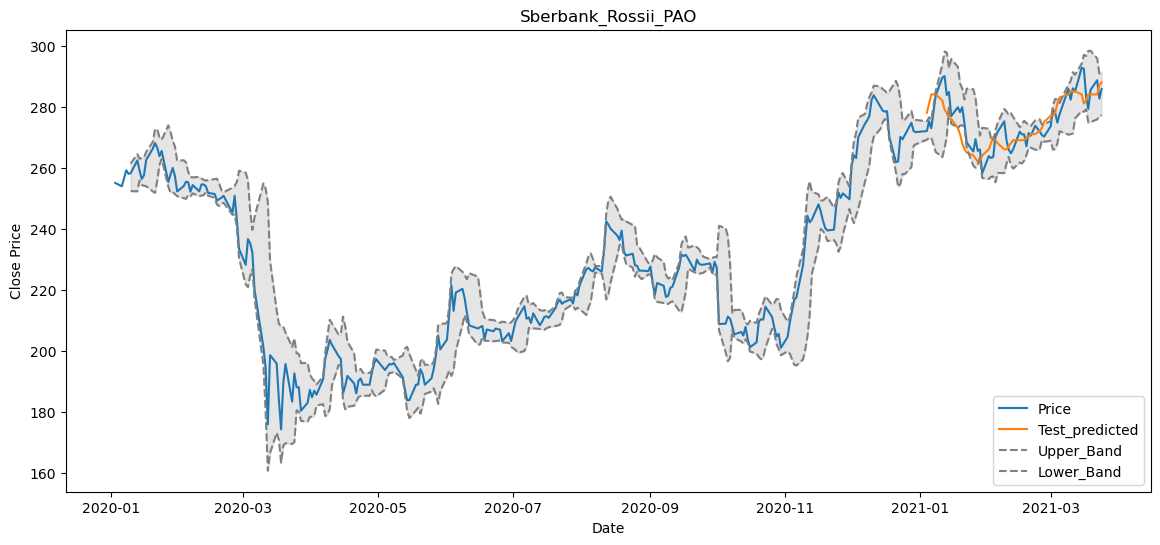

                 Stock       Date   Price  Test_predicted Decision
9  Sberbank_Rossii_PAO 2021-03-18  279.25           284.0     Hold
8  Sberbank_Rossii_PAO 2021-03-19  285.47           284.0     Hold
7  Sberbank_Rossii_PAO 2021-03-22  288.65           284.0     Hold
6  Sberbank_Rossii_PAO 2021-03-23   282.6           287.0     Hold
5  Sberbank_Rossii_PAO 2021-03-24  285.79           288.0     Hold


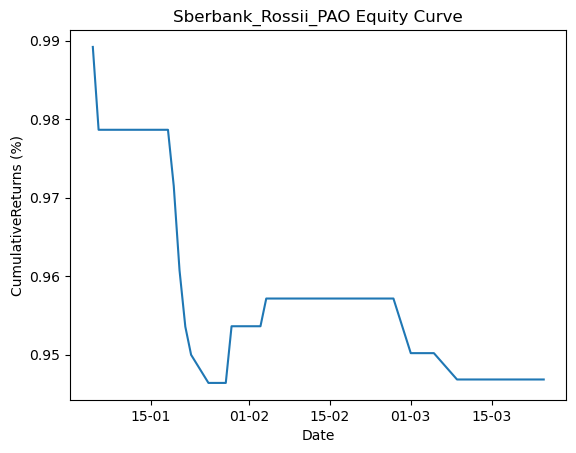

Sberbank_Rossii_PAO MAPE: 1.53
Cumulative return:  0.95 %
2/2 [==============================] - 0s 20ms/step


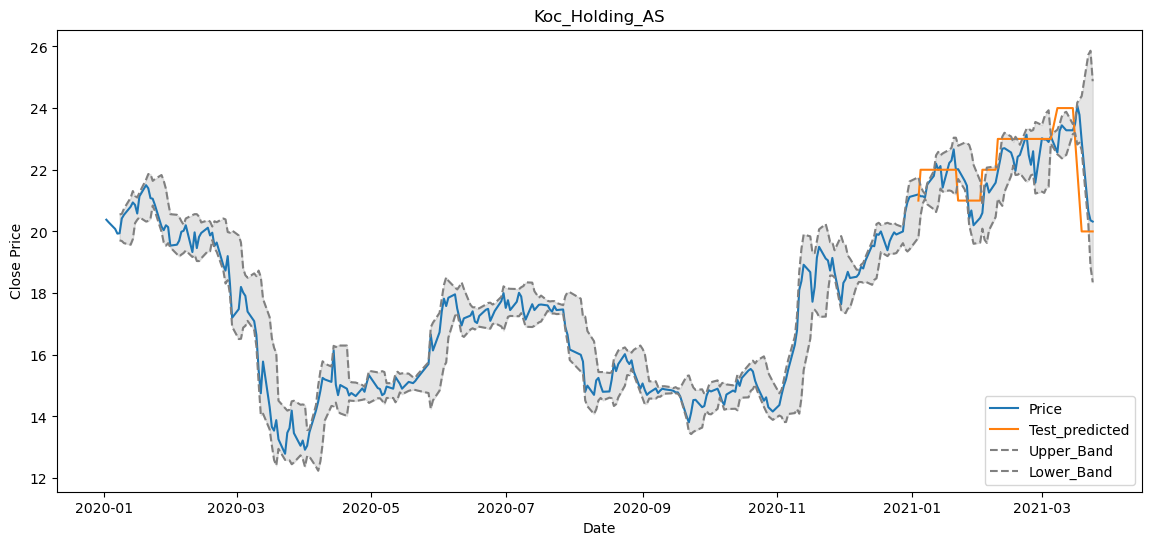

            Stock       Date  Price  Test_predicted Decision
9  Koc_Holding_AS 2021-03-18  23.78            21.0      Buy
8  Koc_Holding_AS 2021-03-19  22.94            20.0      Buy
7  Koc_Holding_AS 2021-03-22  20.66            20.0      Buy
6  Koc_Holding_AS 2021-03-23  20.36            20.0     Hold
5  Koc_Holding_AS 2021-03-24  20.32            20.0     Hold


C:\Users\97158\AppData\Local\Temp\ipykernel_32784\742524563.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Bband_data['Decision']= Decision


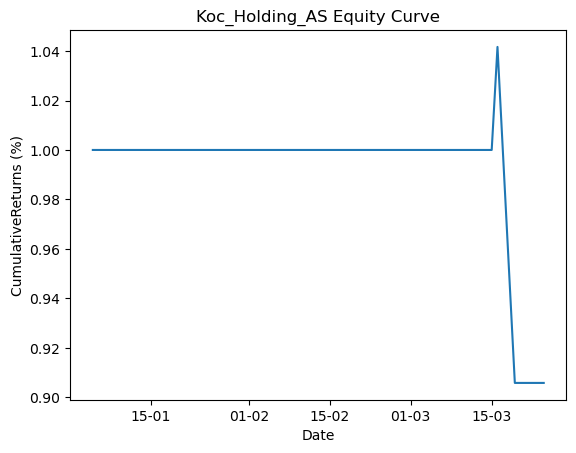

Koc_Holding_AS MAPE: 2.89
Cumulative return:  0.91 %
2/2 [==============================] - 0s 28ms/step


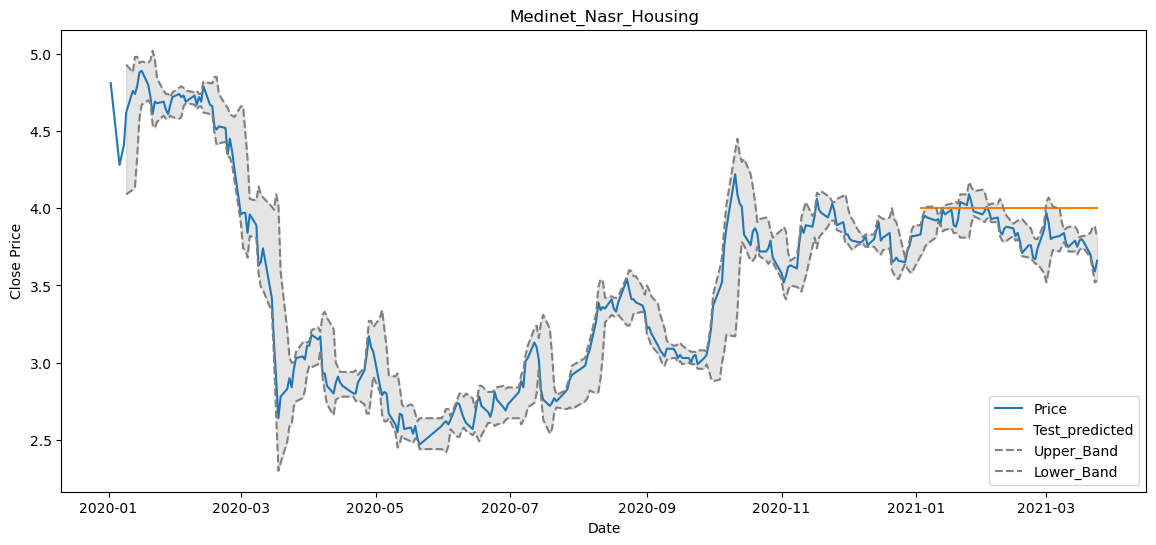

                  Stock       Date Price  Test_predicted Decision
9  Medinet_Nasr_Housing 2021-03-18  3.78             4.0     Sell
8  Medinet_Nasr_Housing 2021-03-21   3.7             4.0     Sell
7  Medinet_Nasr_Housing 2021-03-22  3.63             4.0     Sell
6  Medinet_Nasr_Housing 2021-03-23  3.59             4.0     Sell
5  Medinet_Nasr_Housing 2021-03-24  3.66             4.0     Sell


C:\Users\97158\AppData\Local\Temp\ipykernel_32784\742524563.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Bband_data['Decision']= Decision


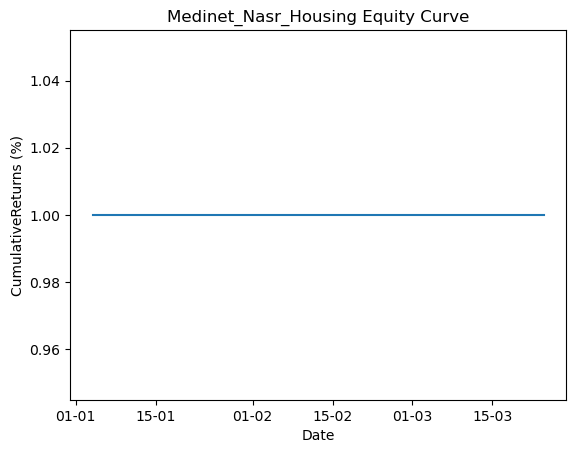

Medinet_Nasr_Housing MAPE: 3.93
Cumulative return:  1.0 %


In [24]:
# Calculating and plotting curves for all the stocks. 

# Calculating and plotting LSTM model performance for first 3 stocks
Stocks=Consol_data['Stock'].unique()[3:4]
All_Country_Predicted= pd.DataFrame()
All_Bband_data= pd.DataFrame()

for Stock in Stocks:
    Test_data_scaled,  model, scaler, n_steps, Train_data_scaled = Train_LSTM(Consol_data, Stock,n_steps=5)

    Predicted_data = Predict_LSTM(Test_data_scaled,model,scaler,n_steps)

    All_Country_Predicted=pd.concat([All_Country_Predicted,Predicted_data])

    Bband_data= Calculate_bands_and_plot(Train_data_scaled.iloc[:,[0,1,2,-2]],Predicted_data,Stock)

    All_Bband_data=pd.concat([All_Bband_data,Bband_data])
    
    print(Make_decision(All_Bband_data,Stock).tail())
    
    Calculate_Equity_Curve(All_Bband_data, Stock)

# Facebook Prophet

In [80]:
Train_data=Consol_data[Consol_data['Date']<='2020-12-31']
Train_data_prohphet=Train_data.iloc[:,[0,1,2,-1]].sort_values(by='Date')
Train_data_prohphet=Train_data.rename(columns={'Date':'ds', 'Price':'y'})
Train_data_prohphet[['ds','y']]


,ds,y
61,2020-12-30,271.65
62,2020-12-29,272
63,2020-12-28,274.7
64,2020-12-25,270.64
65,2020-12-24,269.32
...,...,...
336,2020-01-08,5430
337,2020-01-07,5690
338,2020-01-06,5730
339,2020-01-03,5900


In [81]:
def Train_and_Predict_Prophet(Stock, Raw_data):
    
    country_data = Raw_data[Raw_data['Stock'] == Stock]
    Train_data=country_data[country_data['Date']<='2020-12-31']
    Test_data=country_data[country_data['Date']>'2020-12-31']
    
    Train_data= Train_data.iloc[:,[0,1,2,-1]].sort_values(by='Date')
    Train_data_prohphet=Train_data[['Date','Price']].rename(columns={'Date':'ds', 'Price':'y'})

    Test_data= Test_data.iloc[:,[0,1,2,-1]].sort_values(by='Date')
    Test_data_prohphet=Test_data[['Date','Price']].rename(columns={'Date':'ds', 'Price':'y'})


    model=Prophet(daily_seasonality=True)
    model.fit(Train_data_prohphet)
    #future=model.make_future_dataframe(periods=days_to_predict, freq='D',include_history=False)
    forecast=model.predict(Test_data_prohphet)


    forecast=forecast.rename(columns={'ds':'Date','yhat':'Test_predicted'})
    forecast=forecast[['Date','Test_predicted']]
    test_and_predicted_data=pd.merge(Test_data,forecast,on='Date')


    return Train_data, test_and_predicted_data, Train_data_prohphet

18:43:12 - cmdstanpy - INFO - Chain [1] start processing
18:43:12 - cmdstanpy - INFO - Chain [1] done processing


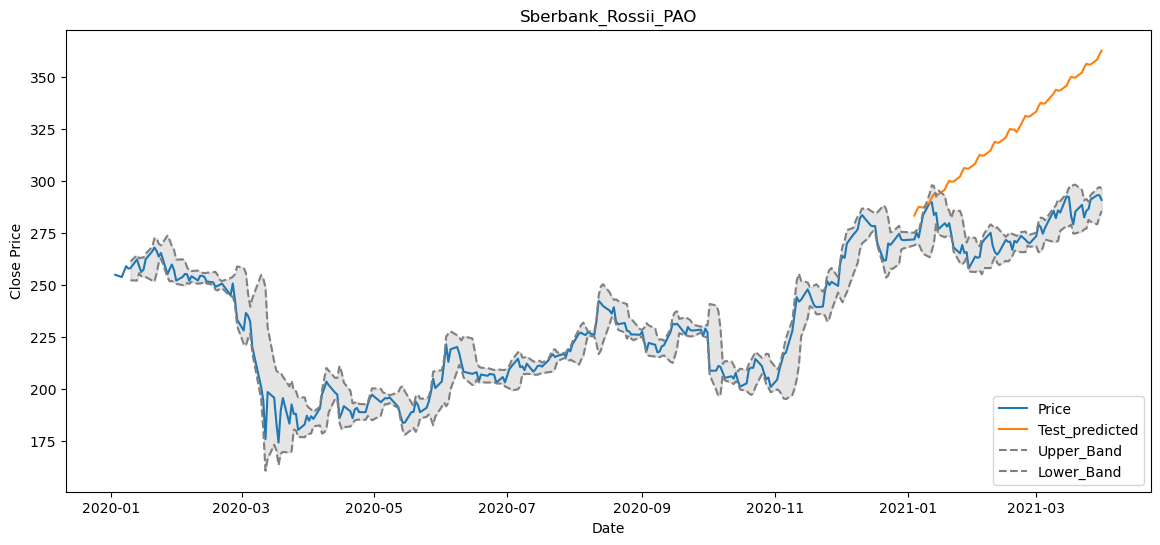

                  Stock       Date   Price  Test_predicted Decision
56  Sberbank_Rossii_PAO 2021-03-25  286.66      356.113358     Sell
57  Sberbank_Rossii_PAO 2021-03-26  291.22      356.199550     Sell
58  Sberbank_Rossii_PAO 2021-03-29   293.3      358.581248     Sell
59  Sberbank_Rossii_PAO 2021-03-30  293.25      360.999859     Sell
60  Sberbank_Rossii_PAO 2021-03-31  291.02      362.792211     Sell


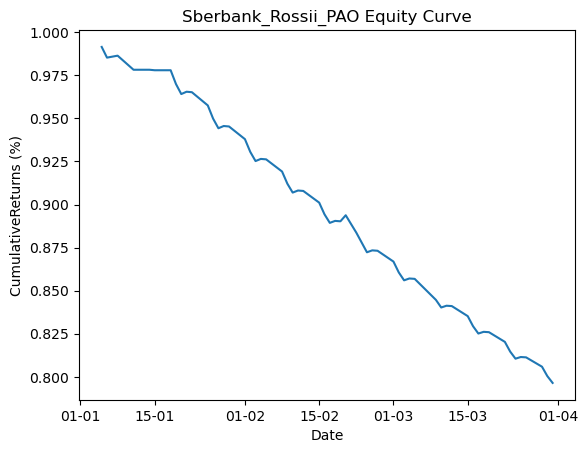

18:43:12 - cmdstanpy - INFO - Chain [1] start processing
18:43:12 - cmdstanpy - INFO - Chain [1] done processing


Sberbank_Rossii_PAO MAPE: 16.66
Cumulative return:  0.8 %


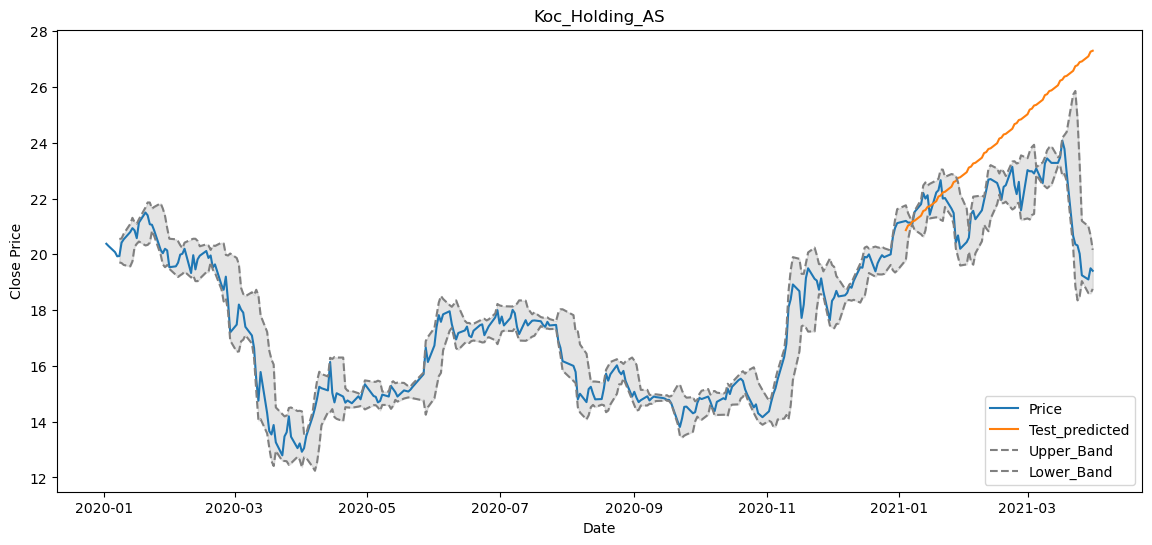

             Stock       Date  Price  Test_predicted Decision
58  Koc_Holding_AS 2021-03-25  20.02       26.895629     Sell
59  Koc_Holding_AS 2021-03-26  19.25       26.919776     Sell
60  Koc_Holding_AS 2021-03-29   19.1       27.102045     Sell
61  Koc_Holding_AS 2021-03-30   19.5       27.268381     Sell
62  Koc_Holding_AS 2021-03-31  19.41       27.303076     Sell


C:\Users\97158\AppData\Local\Temp\ipykernel_32784\742524563.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Bband_data['Decision']= Decision


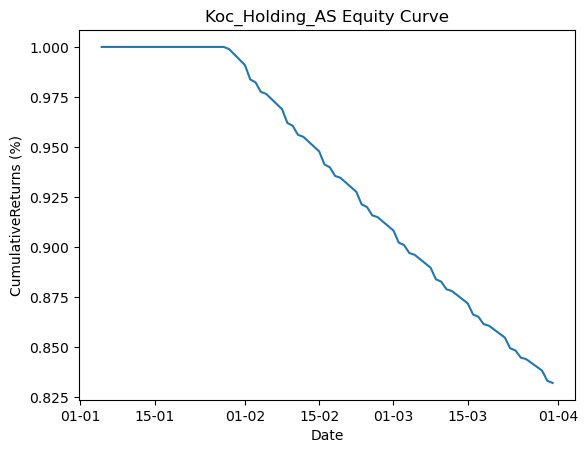

18:43:13 - cmdstanpy - INFO - Chain [1] start processing


Koc_Holding_AS MAPE: 10.95
Cumulative return:  0.83 %


18:43:13 - cmdstanpy - INFO - Chain [1] done processing


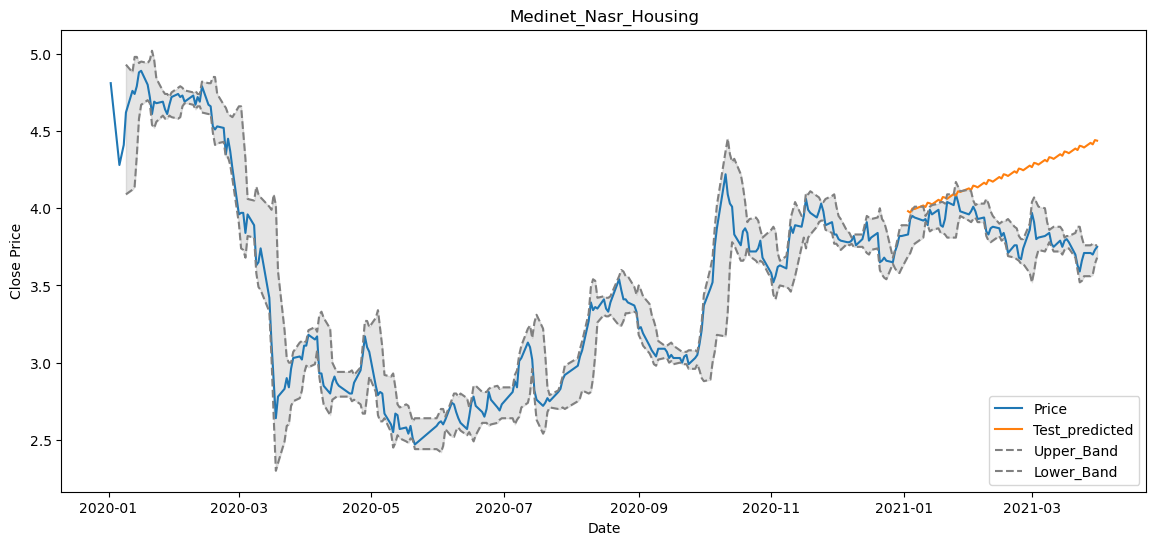

C:\Users\97158\AppData\Local\Temp\ipykernel_32784\742524563.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Bband_data['Decision']= Decision


                   Stock       Date Price  Test_predicted Decision
57  Medinet_Nasr_Housing 2021-03-25  3.71        4.393228     Sell
58  Medinet_Nasr_Housing 2021-03-28  3.71        4.423418     Sell
59  Medinet_Nasr_Housing 2021-03-29   3.7        4.413524     Sell
60  Medinet_Nasr_Housing 2021-03-30  3.73        4.441299     Sell
61  Medinet_Nasr_Housing 2021-03-31  3.75        4.437381     Sell


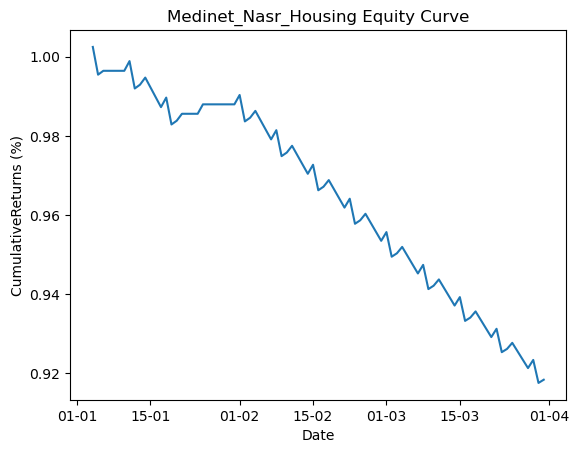

Medinet_Nasr_Housing MAPE: 9.6
Cumulative return:  0.92 %


In [82]:
# Calculating and plotting curves for all the stocks. 

# Calculating and plotting Prophet Model performance for first 3 stocks
Stocks=Consol_data['Stock'].unique()[:3]
All_Prophet_Bband_data= pd.DataFrame()


for Stock in Stocks:    
    Train_data, test_and_predicted_data, Train_data_prohphet = Train_and_Predict_Prophet(Stock, Consol_data)
    Bband_data= Calculate_bands_and_plot(Train_data,test_and_predicted_data, Stock )
    All_Prophet_Bband_data=pd.concat([All_Prophet_Bband_data,Bband_data])
    print(Make_decision(All_Prophet_Bband_data,Stock).tail())
    Calculate_Equity_Curve(All_Prophet_Bband_data, Stock)
    

In [83]:
Train_data
test_and_predicted_data


,Stock,Country,Date,Price,Test_predicted
0,Medinet_Nasr_Housing,Egypt,2021-01-03,3.83,3.980871
1,Medinet_Nasr_Housing,Egypt,2021-01-04,3.93,3.970977
2,Medinet_Nasr_Housing,Egypt,2021-01-05,3.95,3.998752
3,Medinet_Nasr_Housing,Egypt,2021-01-06,3.94,3.994834
4,Medinet_Nasr_Housing,Egypt,2021-01-10,3.92,4.017750
...,...,...,...,...,...
57,Medinet_Nasr_Housing,Egypt,2021-03-25,3.71,4.393228
58,Medinet_Nasr_Housing,Egypt,2021-03-28,3.71,4.423418
59,Medinet_Nasr_Housing,Egypt,2021-03-29,3.7,4.413524
60,Medinet_Nasr_Housing,Egypt,2021-03-30,3.73,4.441299
